# PSP analysis 

In this note, we analyze a dataset for Progressive Supranuclear Palsy (PSP), which includes RNA-Seq data from 25 PSP patients and 16 controls with total of 1675 ENS gene IDs.

- Our analysis begins with a 2-fold cross-validation using XGBoost, where we compute and plot the average AUC, specificity, sensitivity, and accuracy scores with standard deviation error bars.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import os
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from catboost import CatBoostClassifier, Pool, metrics, cv


from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso, Ridge

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import  RandomizedSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold, cross_val_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import precision_score, recall_score, f1_score, roc_curve, accuracy_score, auc
from sklearn.metrics import roc_auc_score, confusion_matrix, precision_recall_curve

from sklearn.svm import SVC


from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from xgboost import XGBClassifier
import xgboost as xgb


from collections import Counter


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
path1=Path("/Users/zainabnazari/all_psp/psp/data")

In [3]:
w_psp_data=pd.read_csv(path1/"mydata_TMM_Norm_Log2_CPM_M1_filtered_STAR_align_HtSeq_top_2212_ParCor_Spearman_p_1pc.txt",delimiter='\t')
w_psp_data;


In [4]:
    df = w_psp_data
    df = df.drop(columns=["ID"])  # Drop 'ID' column (row index now is ENSG ID)

    # Transpose so samples are rows, genes are columns
    df = df.T  # Now shape is (samples, genes)

    # Create labels from sample names
    labels = df.index.to_series().apply(lambda x: 0 if "CTR" in x else 1).values

    # Now: df is your X (features), labels is your y
    X = df.values
    y = labels
    sample_names = df.index
    gene_names = df.columns

    # --- Step 2: Train/Test Split ---
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, stratify=y, random_state=42
    )

    # --- Step 3: Scaling ---
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # --- Step 4: Define XGBoost Model ---
    xgb_model = XGBClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.2,
        subsample=0.8,
        colsample_bytree=0.8,
        use_label_encoder=False,
        eval_metric='logloss',
        random_state=42
    )

    # --- Step 5: Cross-validation AUC ---
    cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    cv_auc_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')
    print(f"Mean CV AUC: {np.mean(cv_auc_scores):.3f} ± {np.std(cv_auc_scores):.3f}")

    # --- Step 6: Train on full training set ---
    xgb_model.fit(X_train_scaled, y_train)

    # --- Step 7: Test set evaluation ---
    y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
    test_auc = roc_auc_score(y_test, y_proba)
    print(f"Test AUC: {test_auc:.3f}")


Mean CV AUC: 0.638 ± 0.117
Test AUC: 0.650


# TOP Genes

In [5]:
# Keep the ID mapping before dropping
id_mapping = w_psp_data.set_index("ID").index.tolist()  # This gives a list of ENSG IDs in order


In [6]:

# Feature importances from trained model
importances = xgb_model.feature_importances_

# Map gene names to their ENSG ID
gene_id_mapping = dict(zip(gene_names, id_mapping))  # gene_name -> ENSG ID

# Map importances to gene names
gene_importance = pd.Series(importances, index=gene_names)

# Sort and get top 20 most important
top_genes = gene_importance.sort_values(ascending=False).head(20)

# Add ENSG ID to results
top_genes_df = pd.DataFrame({
    "ENSG_ID": [gene_id_mapping.get(gene) for gene in top_genes.index],
    "Importance": top_genes.values
})

# Show results
print("\n🧬 Top 20 Genes with ENSG IDs:")
print(top_genes_df)




🧬 Top 20 Genes with ENSG IDs:
            ENSG_ID  Importance
0   ENSG00000275902    0.108393
1   ENSG00000261474    0.105021
2   ENSG00000149091    0.085973
3   ENSG00000291118    0.063467
4   ENSG00000287170    0.060069
5   ENSG00000111639    0.048988
6   ENSG00000172732    0.048566
7   ENSG00000244480    0.046702
8   ENSG00000007038    0.044477
9   ENSG00000198520    0.039362
10  ENSG00000122783    0.034873
11  ENSG00000288915    0.028202
12  ENSG00000272977    0.027665
13  ENSG00000240809    0.024341
14  ENSG00000122952    0.024333
15  ENSG00000168255    0.022644
16  ENSG00000176953    0.022265
17  ENSG00000113504    0.017249
18  ENSG00000247796    0.016740
19  ENSG00000175691    0.016514


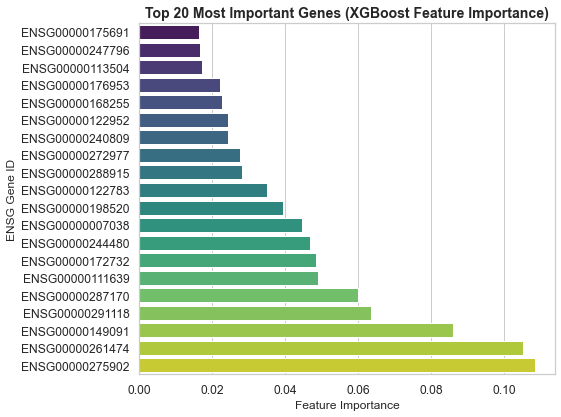

In [8]:
# Sort for plotting (ascending so bars grow upward)
top_genes_df = top_genes_df.sort_values("Importance", ascending=True)

# Set seaborn theme
sns.set(style="whitegrid", font_scale=1.1)

# Plot
plt.figure(figsize=(8, 6))
ax = sns.barplot(
    data=top_genes_df,
    x="Importance",
    y="ENSG_ID",
    palette="viridis"
)

# Aesthetics
ax.set_title("Top 20 Most Important Genes (XGBoost Feature Importance)", fontsize=14, weight='bold')
ax.set_xlabel("Feature Importance", fontsize=12)
ax.set_ylabel("ENSG Gene ID", fontsize=12)
plt.tight_layout()

# Optional: Save to file
# plt.savefig("top_genes_feature_importance.png", dpi=300)

plt.show()


# Pearson Correlated with Clinical

In [9]:
pearson_c=pd.read_csv(path1/"pearson_clinical.csv",delimiter=',')
pearson_c;

In [14]:
pearson_c.columns

Index(['var1', 'var2', 'corr', 'corr_CI5%', 'corr_CI95%', 'pvalue',
       'FDR_corrected_Pval', 'Bonferroni_corrected_Pval',
       'N_non_Null_elements', 'ParCor', 'ParCor_Pval', 'ParCor_FDR',
       'ParCor_Bonferroni'],
      dtype='object')

In [35]:
pearson_c['var1'].duplicated().any()


True

In [10]:
unique = pearson_c['var2'].unique()
unique_list =list(unique)
unique_list

['nms_mood_cognition',
 'nms_gastrointestinal',
 'nms_perceptual_hallucinations',
 'psp_stage',
 'psp_scale_bulbar_exam',
 'nms_cardiovascular_falls',
 'nms_sleep_fatigue',
 'psp_scale_ocular_motor_exam',
 'nms_urinary',
 'psp_scaleHist',
 'TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait',
 'psp_scale_mental_exam',
 'TOTAL_nms',
 'psp_scale_gait',
 'nms_attention_memory',
 'psp_scale_limb_exam',
 'nms_miscellaneous',
 'nms_sexual']

In [11]:
grouped =pearson_c.groupby('var2')['var1'].apply(list)


In [12]:
result_df = grouped.to_frame().T
result_df.columns

Index(['TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait', 'TOTAL_nms',
       'nms_attention_memory', 'nms_cardiovascular_falls',
       'nms_gastrointestinal', 'nms_miscellaneous', 'nms_mood_cognition',
       'nms_perceptual_hallucinations', 'nms_sexual', 'nms_sleep_fatigue',
       'nms_urinary', 'psp_scaleHist', 'psp_scale_bulbar_exam',
       'psp_scale_gait', 'psp_scale_limb_exam', 'psp_scale_mental_exam',
       'psp_scale_ocular_motor_exam', 'psp_stage'],
      dtype='object', name='var2')

In [13]:
whole_clinical_name= list(result_df)
whole_clinical_name

['TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait',
 'TOTAL_nms',
 'nms_attention_memory',
 'nms_cardiovascular_falls',
 'nms_gastrointestinal',
 'nms_miscellaneous',
 'nms_mood_cognition',
 'nms_perceptual_hallucinations',
 'nms_sexual',
 'nms_sleep_fatigue',
 'nms_urinary',
 'psp_scaleHist',
 'psp_scale_bulbar_exam',
 'psp_scale_gait',
 'psp_scale_limb_exam',
 'psp_scale_mental_exam',
 'psp_scale_ocular_motor_exam',
 'psp_stage']

In [14]:
result_dict = {}

# grouped is a Series: index = clinical_measure, values = list of ENSG IDs
for clinical_measure, gene_list in grouped.items():
    # Filter rows from data_norm using the list of ENSG IDs
    filtered_df = w_psp_data[w_psp_data['ID'].isin(gene_list)].copy()
    
    # Store the filtered DataFrame in a dictionary
    result_dict[clinical_measure] = filtered_df


for name in whole_clinical_name:
    globals()[name] = result_dict.get(name)


In [15]:


for name in whole_clinical_name:
    print(f"\n🔬 Processing: {name}")
    
    df = result_dict.get(name, None)
    if df is None or df.empty:
        print(f"⚠️ No data found for {name}. Skipping.")
        continue
    
    try:
        # --- Step 1: Data Preparation ---
        df = df.drop(columns=["ID"], errors="ignore")  # Drop 'ID' column (row index now is ENSG ID)
        df = df.T  # Transpose so samples are rows, genes are columns

        # Create labels from sample names
        labels = df.index.to_series().apply(lambda x: 0 if "CTR" in x else 1).values

        # Check if both classes are present
        if len(np.unique(labels)) < 2:
            print("⚠️ Only one class present in data. Skipping.")
            continue

        X = df.values
        y = labels

        # --- Step 2: Train/Test Split ---
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.5, stratify=y, random_state=42
        )

        # --- Step 3: Scaling ---
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # --- Step 4: Define XGBoost Model ---
        xgb_model = XGBClassifier(
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            subsample=0.8,
            colsample_bytree=0.8,
            use_label_encoder=False,
            eval_metric='logloss',
            random_state=42
        )

        # --- Step 5: Cross-validation AUC ---
        cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
        cv_auc_scores = cross_val_score(xgb_model, X_train_scaled, y_train, cv=cv, scoring='roc_auc')

        mean_cv_auc = np.mean(cv_auc_scores)
        std_cv_auc = np.std(cv_auc_scores)
        print(f"  🔁 Mean CV AUC: {mean_cv_auc:.3f} ± {std_cv_auc:.3f}")

            

        # --- Step 6: Train on full training set ---
        xgb_model.fit(X_train_scaled, y_train)

        # --- Step 7: Test set evaluation ---
        y_proba = xgb_model.predict_proba(X_test_scaled)[:, 1]
        test_auc = roc_auc_score(y_test, y_proba)
        print(f"  🧪 Test AUC: {test_auc:.3f}")

    except Exception as e:
        print(f"❌ Error processing {name}: {e}")



🔬 Processing: TOTAL_PSP_hist_mental_bulbar_ocular_limb_gait
  🔁 Mean CV AUC: 0.708 ± 0.167
  🧪 Test AUC: 0.519

🔬 Processing: TOTAL_nms
  🔁 Mean CV AUC: 0.417 ± 0.000
  🧪 Test AUC: 0.625

🔬 Processing: nms_attention_memory
  🔁 Mean CV AUC: 0.312 ± 0.104
  🧪 Test AUC: 0.615

🔬 Processing: nms_cardiovascular_falls
  🔁 Mean CV AUC: 0.521 ± 0.021
  🧪 Test AUC: 0.577

🔬 Processing: nms_gastrointestinal
  🔁 Mean CV AUC: 0.667 ± 0.250
  🧪 Test AUC: 0.481

🔬 Processing: nms_miscellaneous
  🔁 Mean CV AUC: 0.667 ± 0.042
  🧪 Test AUC: 0.279

🔬 Processing: nms_mood_cognition
  🔁 Mean CV AUC: 0.573 ± 0.135
  🧪 Test AUC: 0.596

🔬 Processing: nms_perceptual_hallucinations
  🔁 Mean CV AUC: 0.438 ± 0.000
  🧪 Test AUC: 0.644

🔬 Processing: nms_sexual
  🔁 Mean CV AUC: 0.562 ± 0.042
  🧪 Test AUC: 0.298

🔬 Processing: nms_sleep_fatigue
  🔁 Mean CV AUC: 0.552 ± 0.135
  🧪 Test AUC: 0.606

🔬 Processing: nms_urinary
  🔁 Mean CV AUC: 0.542 ± 0.125
  🧪 Test AUC: 0.673

🔬 Processing: psp_scaleHist
  🔁 Mean CV AU